# GCNConv Model Evaluation

This notebook walks throught the evaluation of a GCN Model utilising GCNConv layers provided by the PyTorch Geometric package.

In [1]:
import pandas as pd
import numpy as np
import torch
import networkx as nx
from torch_geometric.utils import from_networkx, to_networkx
from torch_geometric.data import Data
from rdkit import Chem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
from preprocessing.featurisation import get_atom_features, get_bond_features
from preprocessing.fetch_smiles import resolve_smiles_by_cas_interactive
from preprocessing.smiles_to_graph import batch_from_csv


## Importing the data

The first step is to import the data that can be found in the `data/processed` folders.

In [2]:
# Produce SMILES strings from CAS numbers
# df = resolve_smiles_by_cas_interactive("data/raw/Ozkan_data_2024.xlsx", "data/processed/input.csv")

# Convert smiles strings in the CSV file to a list of PyTorch graphs
graph_list = batch_from_csv("data/processed/input.csv")
molecules_df = pd.read_csv("data/processed/input.csv")


In [3]:
num_node_features = graph_list[0].num_node_features
num_edge_features = graph_list[0].num_edge_features
avg_degree = 2*(graph_list[0].num_edges) / graph_list[0].num_nodes
print(f"Number of node features: {num_node_features}")
print(f"Average degree of the graph: {avg_degree:.2f}") # From the avg. degree we can use at least 4 GCNConv layers
print(f"Number of edge features: {num_edge_features}")


Number of node features: 79
Average degree of the graph: 4.00
Number of edge features: 10


In [4]:
graph_list[0].x.shape, graph_list[0].edge_index.shape

(torch.Size([8, 79]), torch.Size([2, 16]))

In [5]:
graph_list[0].y

tensor([5.2900])

The variance of our dataset target values are given by the cell below. The variance is 32.065 - meaning that it has significant spread making our graph-level regression task more difficult for our model.

In [6]:
ys = np.array([data.y.item() for data in graph_list])
variance = np.var(ys)  # Use ddof=1 for sample variance
print("Variance:", variance)

Variance: 32.06530972525442


## Model Training and Prediction Eval Functions

Random seed to ensure reproducibility of results and consistent random weight initialisations.

In [7]:
import torch
import random
import numpy as np

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(123)


Training function for the GCN model - taking batched data.
Followed by the plot predictions function to visualise the accuracy of the predicitons made.

In [8]:
# TODO: experiment with batch size of 8. 

from torch.nn import MSELoss
from torch_geometric.loader import DataLoader

def train_gcn_model_batched(dataloader, model, lr=1e-3, epochs=300):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = MSELoss()

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index, batch.batch).squeeze()
            target = batch.y.squeeze()

            assert out.shape == target.shape, f"{out.shape=} vs {target.shape=}"
            loss = loss_fn(out, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")
    
    return model

train_loader = DataLoader(graph_list, batch_size=32, shuffle=True)

In [9]:
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_predictions(dataloader, model):
    """
    Function to plot predictions vs actual values.
    """
    all_preds = [] 
    all_targets = []

    # Put model in evaluation mode
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            preds = model(batch.x, batch.edge_index, batch.batch).squeeze()
            targets = batch.y.squeeze()

            # Handle possible shape mismatches
            if preds.dim() == 0:
                preds = preds.unsqueeze(0)
            if targets.dim() == 0:
                targets = targets.unsqueeze(0)

            all_preds.append(preds.cpu())
            all_targets.append(targets.cpu())

    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_targets = torch.cat(all_targets, dim=0).numpy()

    # Compute metrics
    r2 = r2_score(all_targets, all_preds)
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))

    print(f"R² score: {r2:.3f}")
    print(f"RMSE: {rmse:.3f}")

    # Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(all_targets, all_preds, alpha=0.7)
    plt.plot([all_targets.min(), all_targets.max()],
             [all_targets.min(), all_targets.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Predicted vs. Actual - GCN Model (Batched)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [10]:
import plotly
plotly.__version__

'6.2.0'

In [11]:
molecules_df.head()

,Inhibitor Name,CAS Number,Inh Power,SMILES
0,1-H-imidazole-2-carboxylic acid,16042-25-4,5.29,C1=CN=C(N1)C(=O)O
1,1-methyl-1-H-benzimidazole-2-thiol,2360-22-7,10.04,CN1C2=CC=CC=C2NC1=S
2,1-methyl-benzimidazole,1632-83-3,-0.51,CN1C=NC2=CC=CC=C21
3,"1,2,4-triazole",288-88-0,2.09,C1=NC=NN1
4,"1,3-diisopropyl-2-thiourea",2986-17-6,3.54,CC(C)NC(=S)NC(C)C


In [12]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
import torch

def plot_predictions_plotly(dataloader, model, metadata_df=None):
    """
    Function to plot predictions vs actual values using Plotly with hover tooltips.
    
    metadata_df: Optional DataFrame with molecule metadata.
                 Should have at least as many rows as total predictions.
                 Example columns: MoleculeName, SMILES, CAS.
    """
    all_preds = []
    all_targets = []

    # Put model in eval mode
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            preds = model(batch.x, batch.edge_index, batch.batch).squeeze()
            targets = batch.y.squeeze()

            if preds.dim() == 0:
                preds = preds.unsqueeze(0)
            if targets.dim() == 0:
                targets = targets.unsqueeze(0)

            all_preds.append(preds.cpu())
            all_targets.append(targets.cpu())

    # Flatten
    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_targets = torch.cat(all_targets, dim=0).numpy()

    # Compute metrics
    r2 = r2_score(all_targets, all_preds)
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))

    print(f"R² score: {r2:.3f}")
    print(f"RMSE: {rmse:.3f}")

    # Build DataFrame
    df = pd.DataFrame({
        "Actual": all_targets,
        "Predicted": all_preds
    })

    # Merge metadata if available
    if metadata_df is not None:
        metadata_df = metadata_df.reset_index(drop=True)
        df = pd.concat([df, metadata_df.iloc[:len(df)].reset_index(drop=True)], axis=1)

    # Make plot
    fig = px.scatter(
        df,
        x="Actual",
        y="Predicted",
        hover_data={
            "Inhibitor Name": True,
            "Inh Power": False, #':.2f',
            "CAS Number": False,
            "SMILES": False
        },
        title="Predicted vs Actual - GCNModel (Batched)",
        labels={"Actual": "Actual", "Predicted": "Predicted"},
        height=600,
        width=600
    )

    # Identity line y=x
    fig.add_shape(
        type="line",
        x0=df["Actual"].min(),
        y0=df["Actual"].min(),
        x1=df["Actual"].max(),
        y1=df["Actual"].max(),
        line=dict(color="red", dash="dash"),
    )

    fig.update_traces(marker=dict(size=8, opacity=0.7))
    fig.update_layout(showlegend=False)
    fig.show()



In [13]:
molecules_df.columns

Index(['Inhibitor Name', 'CAS Number', 'Inh Power', 'SMILES'], dtype='object')

## Model Creation

In [14]:
import torch
from torch.nn import Linear, ReLU, Dropout, Sequential
from torch_geometric.nn import GCNConv, global_mean_pool

class GCNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_dim, out_dim=1, dropout_rate=0.2):
        super().__init__()

        # GCN layers
        self.conv1 = GCNConv(in_channels, hidden_dim)


        # Feedforward MLP for regression
        self.ffnn = Sequential(
            Linear(hidden_dim, hidden_dim),
            ReLU(),
            Dropout(dropout_rate),
            Linear(hidden_dim, out_dim)
        )

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)

        # batch = torch.zeros(x.size(0), dtype=torch.long)
        x = global_mean_pool(x, batch)
        out = self.ffnn(x)
        return out


In [15]:
model = GCNModel(in_channels=num_node_features, hidden_dim=64, out_dim=1)
print(model)

GCNModel(
  (conv1): GCNConv(79, 64)
  (ffnn): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)


### Training the model

In [16]:
train_gcn_model_batched(train_loader, model, lr=1e-3, epochs=300)

Epoch 1, Loss: 127.3639
Epoch 2, Loss: 112.9740
Epoch 3, Loss: 161.5855
Epoch 4, Loss: 131.4401
Epoch 5, Loss: 117.0489
Epoch 6, Loss: 109.6832
Epoch 7, Loss: 96.7875
Epoch 8, Loss: 144.7570
Epoch 9, Loss: 110.7572
Epoch 10, Loss: 119.5154
Epoch 11, Loss: 113.3492
Epoch 12, Loss: 119.9700
Epoch 13, Loss: 113.1936
Epoch 14, Loss: 79.4117
Epoch 15, Loss: 109.1098
Epoch 16, Loss: 150.0530
Epoch 17, Loss: 98.8325
Epoch 18, Loss: 93.0763
Epoch 19, Loss: 109.2878
Epoch 20, Loss: 85.4665
Epoch 21, Loss: 96.0656
Epoch 22, Loss: 92.4807
Epoch 23, Loss: 74.3207
Epoch 24, Loss: 93.0451
Epoch 25, Loss: 91.0041
Epoch 26, Loss: 81.1442
Epoch 27, Loss: 105.9704
Epoch 28, Loss: 84.4080
Epoch 29, Loss: 82.1093
Epoch 30, Loss: 89.7802
Epoch 31, Loss: 79.7812
Epoch 32, Loss: 77.6220
Epoch 33, Loss: 90.4370
Epoch 34, Loss: 79.3118
Epoch 35, Loss: 76.3429
Epoch 36, Loss: 69.2918
Epoch 37, Loss: 89.6675
Epoch 38, Loss: 95.2106
Epoch 39, Loss: 90.2390
Epoch 40, Loss: 77.5681
Epoch 41, Loss: 102.8748
Epoch 42

GCNModel(
  (conv1): GCNConv(79, 64)
  (ffnn): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)


### Evaluating model accuracy

R² score: 0.571
RMSE: 3.708


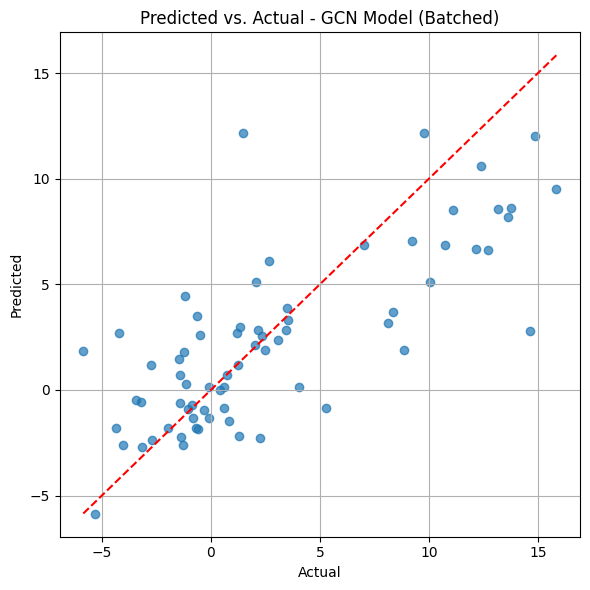

In [17]:
plot_predictions(graph_list, model)

In [18]:
# Create unshuffled evaluation loader so that data labels match the correct graph
eval_loader = DataLoader(graph_list, batch_size=32, shuffle=False)
plot_predictions_plotly(eval_loader, model, metadata_df=molecules_df)

R² score: 0.571
RMSE: 3.708


#### Low Inh Power molecule cluster
- Potassium sodium tartrate
- Oxalic acid
- Tryptamine
- Thiolactic acid
- L-tryptophan
- Nicotinic acid
- 2-picolinic acid
- Sodium lauroylsarcosine
- 1,4-butanediol diglycydyl ether
- Sodium dodecyl benzenesulfonate
- Anthranilic acid
- 3-amino-1,2,4-triazole-5-carboxylic acid
- Isonicotonic acid
- Hexamethylenetetramine
- Salycilic acid
- Calcium D-gluconate monohydrate
- Sodium benzoate


In [19]:
# def visualize_mol(G, color=None, name=None):
#     plt.figure(figsize=(7,7))
#     plt.xticks([])
#     plt.yticks([])
#     if name is not None:
#         plt.title(f"Graph: {name}")
#     nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
#                      node_color=color, cmap="Set2")
#     plt.show()

def visualize_mol(G, name=None, ax=None):
    """
    G: networkx graph
    name: optional title
    ax: matplotlib Axes object
    """
    import matplotlib.pyplot as plt
    import networkx as nx

    if ax is None:
        fig, ax = plt.subplots(figsize=(3,3))

    pos = nx.spring_layout(G, seed=42)
    nx.draw(
        G,
        pos,
        with_labels=False,
        node_size=50,
        node_color="skyblue",
        edge_color="gray",
        ax=ax
    )
    if name:
        ax.set_title(name, fontsize=8)
    ax.axis("off")


### Low Inhibition Power Molecules

In [20]:
low_pwr_cluster_mols = [
    "Potassium sodium tartrate",
    "Oxalic acid",
    "Tryptamine",
    "Thiolactic acid",
    "L-tryptophan",
    "Nicotinic acid",
    "2-picolinic acid",
    "Sodium lauroylsarcosine",
    "1,4-butanediol diglycydyl ether",
    "Sodium dodecyl benzenesulfonate",
    "Anthranilic acid",
    "3-amino-1,2,4-triazole-5-carboxylic acid",
    "Isonicotonic acid",
    "Hexamethylenetetramine",
    "Salycilic acid",
    "Calcium D-gluconate monohydrate",
    "Sodium benzoate"
]
low_pwr_indices = []
for mol in low_pwr_cluster_mols:
    if mol in molecules_df["Inhibitor Name"].values:
        low_pwr_indices.append(molecules_df[molecules_df["Inhibitor Name"] == mol].index[0])
    else:
        print(f"NOT FOUND: {mol}")
low_pwr_indices

NOT FOUND: 3-amino-1,2,4-triazole-5-carboxylic acid
NOT FOUND: Isonicotonic acid
NOT FOUND: Salycilic acid


[np.int64(49),
 np.int64(47),
 np.int64(68),
 np.int64(64),
 np.int64(44),
 np.int64(46),
 np.int64(17),
 np.int64(58),
 np.int64(6),
 np.int64(57),
 np.int64(30),
 np.int64(41),
 np.int64(36),
 np.int64(55)]

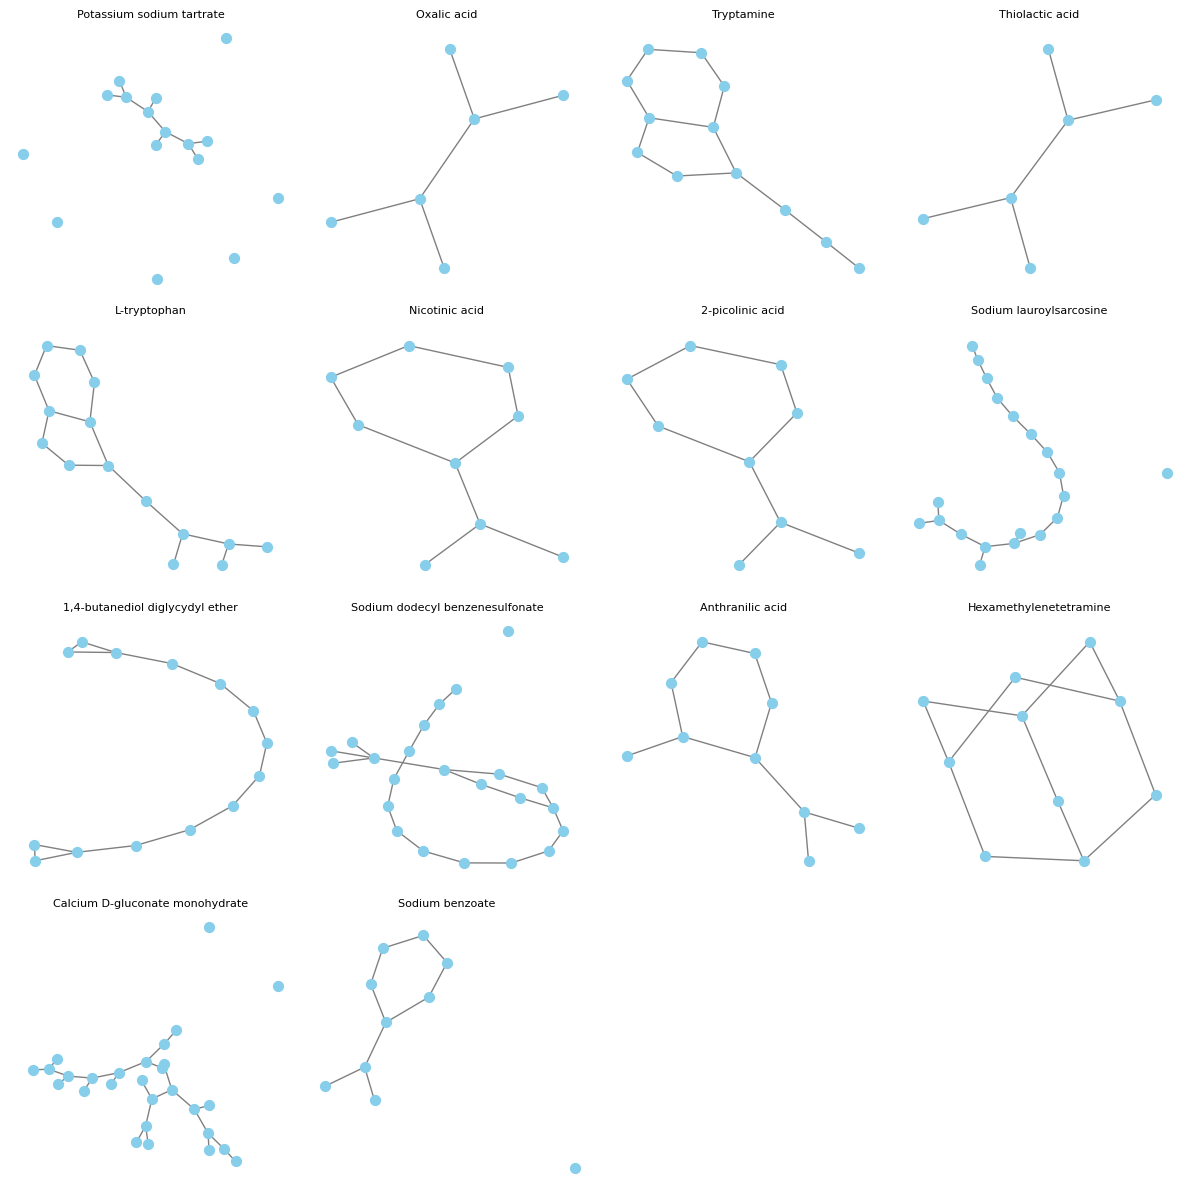

In [21]:
import math
import matplotlib.pyplot as plt

num_mols = len(low_pwr_indices)
cols = 4
rows = math.ceil(num_mols / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))

# Flatten in case of single row
axes = axes.flatten()

for i, idx in enumerate(low_pwr_indices):
    G = to_networkx(graph_list[idx], to_undirected=True)
    name = molecules_df["Inhibitor Name"][idx]
    visualize_mol(G, name=name, ax=axes[i])

# Hide unused axes
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


In [22]:
# for idx in low_pwr_indices:
#     graph = graph_list[idx]
#     G = to_networkx(graph, to_undirected=True)
#     visualize_mol(G, name=molecules_df["Inhibitor Name"][idx])

### High Inhibition Power Molecules

In [23]:
high_pwr_cluster_mols = [
    "Benzotriazole",
    "2-mercapto-1-methylimidazole",
    "Sulfathiazole",
    "Ampicilin trihydrate", #Not found in dataset
    "1,3,4-thiadiazole-2,5-dithiol dipotassium salt", #Not found in dataset
    "Dithiooxononamide",
    "1-methyl-1-H-benzimidazole-2-thiol",
    "Sodium thiosalicylate",
    "Sodium diethyldithiocarbomate",
    "2-mercaptobenzothiazole",
    "3-amino-5-mercapto-1,2,4-triazole",
    "Sodium mercaptoacetate",
    "2-mercaptopyridine",
    "2-mercaptopyrimidine",
    "2-mercaptobenzimidazole",
    "Ammonium pyrrolidinedithiocarbamate"
]
high_pwr_indices = []
for mol in high_pwr_cluster_mols:
    if mol in molecules_df["Inhibitor Name"].values:
        high_pwr_indices.append(molecules_df[molecules_df["Inhibitor Name"] == mol].index[0])
    else:
        print(f"NOT FOUND: {mol}")

NOT FOUND: Ampicilin trihydrate
NOT FOUND: Dithiooxononamide


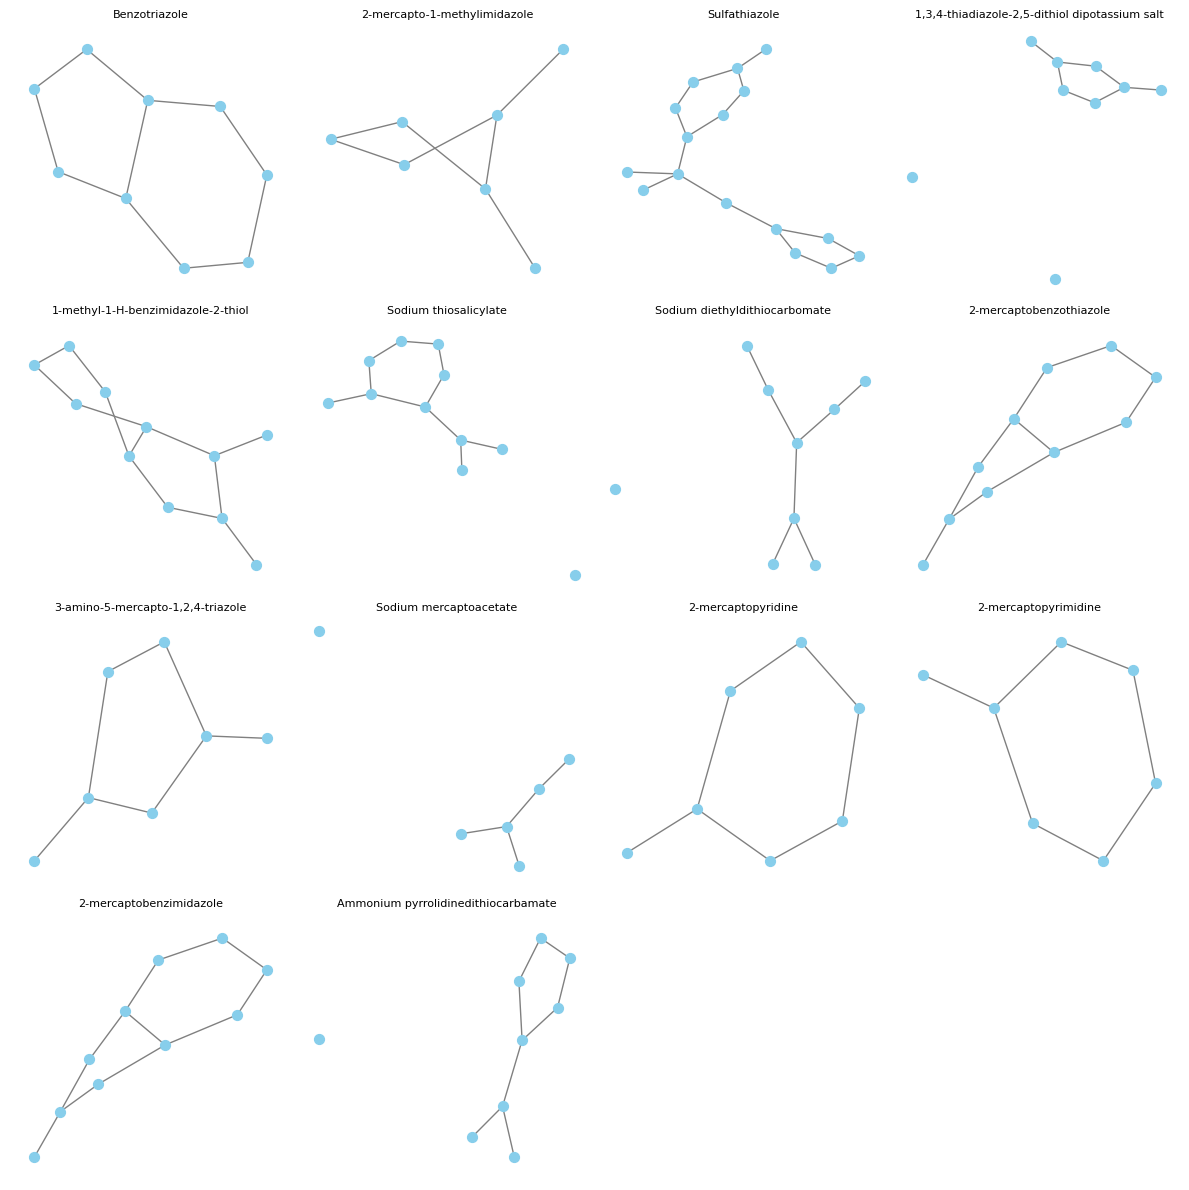

In [24]:
import math
import matplotlib.pyplot as plt

num_mols = len(high_pwr_indices)
cols = 4
rows = math.ceil(num_mols / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))

# Flatten in case of single row
axes = axes.flatten()

for i, idx in enumerate(high_pwr_indices):
    G = to_networkx(graph_list[idx], to_undirected=True)
    name = molecules_df["Inhibitor Name"][idx]
    visualize_mol(G, name=name, ax=axes[i])

# Hide unused axes
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


In [25]:
# for idx in high_pwr_indices:
#     graph = graph_list[idx]
#     G = to_networkx(graph, to_undirected=True)
#     visualize_mol(G, name=molecules_df["Inhibitor Name"][idx])

*Note*: ***From a simple view we can see that these molecules that have a high inhibition power, a lot of them have ring structures, OR they are a salt containing sodium.***

## UMAP using Extended Connectivity Fingerprints (ECFPs)

In [26]:
#TODO:[Chiara] From this:
# • Where are the outliers in the GNN pareto plot in this graph? I suppose they’ll be in the trailing bit….
# • What are the common chemical properties in the two clusters? Can you extract the molecule name/SMILE for a couple of molecules in the bottom right and a couple for the top left cluster.

In [27]:
molecules_df.head()

,Inhibitor Name,CAS Number,Inh Power,SMILES
0,1-H-imidazole-2-carboxylic acid,16042-25-4,5.29,C1=CN=C(N1)C(=O)O
1,1-methyl-1-H-benzimidazole-2-thiol,2360-22-7,10.04,CN1C2=CC=CC=C2NC1=S
2,1-methyl-benzimidazole,1632-83-3,-0.51,CN1C=NC2=CC=CC=C21
3,"1,2,4-triazole",288-88-0,2.09,C1=NC=NN1
4,"1,3-diisopropyl-2-thiourea",2986-17-6,3.54,CC(C)NC(=S)NC(C)C


In [28]:
molecules_df.columns

Index(['Inhibitor Name', 'CAS Number', 'Inh Power', 'SMILES'], dtype='object')

In [29]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
import numpy as np

# Function to get Morgan fingerprint (ECFP)
def get_ecfp(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)
    arr = np.zeros((1,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

# Compute fingerprints for all molecules
ecfps = np.array([get_ecfp(sm) for sm in molecules_df["SMILES"]])
print(ecfps.shape)   # Should be (70, 2048)


(70, 2048)


[00:21:12] DEPRECATION WARNING: please use MorganGenerator
[00:21:12] DEPRECATION WARNING: please use MorganGenerator
[00:21:12] DEPRECATION WARNING: please use MorganGenerator
[00:21:12] DEPRECATION WARNING: please use MorganGenerator
[00:21:12] DEPRECATION WARNING: please use MorganGenerator
[00:21:12] DEPRECATION WARNING: please use MorganGenerator
[00:21:12] DEPRECATION WARNING: please use MorganGenerator
[00:21:12] DEPRECATION WARNING: please use MorganGenerator
[00:21:12] DEPRECATION WARNING: please use MorganGenerator
[00:21:12] DEPRECATION WARNING: please use MorganGenerator
[00:21:12] DEPRECATION WARNING: please use MorganGenerator
[00:21:12] DEPRECATION WARNING: please use MorganGenerator
[00:21:12] DEPRECATION WARNING: please use MorganGenerator
[00:21:12] DEPRECATION WARNING: please use MorganGenerator
[00:21:12] DEPRECATION WARNING: please use MorganGenerator
[00:21:12] DEPRECATION WARNING: please use MorganGenerator
[00:21:12] DEPRECATION WARNING: please use MorganGenerat

In [30]:
import umap

umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=123) #, metric="rogerstanimoto")
umap_embeddings = umap_model.fit_transform(ecfps)
print(umap_embeddings.shape)   # (70, 2)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



(70, 2)


In [31]:
import plotly.express as px
df_umap = molecules_df.copy()
df_umap["UMAP 1"] = umap_embeddings[:,0]
df_umap["UMAP 2"] = umap_embeddings[:,1]


fig = px.scatter(
    df_umap,
    x="UMAP 1",
    y="UMAP 2",
    color="Inh Power",
    hover_data=["Inhibitor Name", "SMILES", "Inh Power"],
    title="UMAP projection of ECFPs colored by Inhibition Power",
    color_continuous_scale=None
)
fig.update_layout(
    width=700,
    height=600
)
fig.show()


## Predicting an arbitrary molcule

In [32]:
def visualize_graph(G, color=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:1438: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



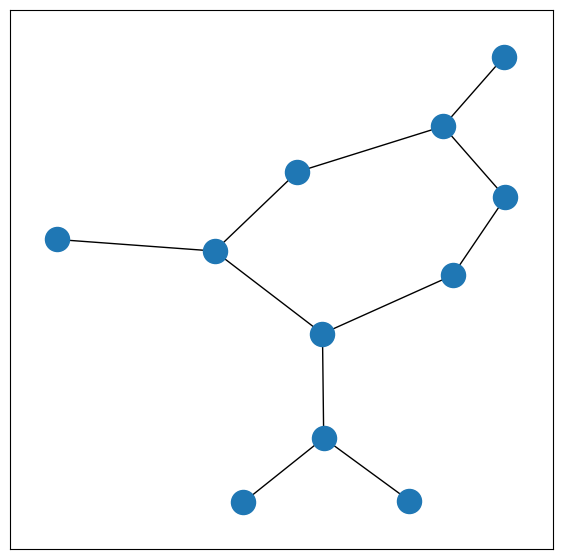

In [33]:
G = to_networkx(graph_list[23], to_undirected=True)
visualize_graph(G)

In [34]:
mol_to_predict = [graph_list[23]]
mol_to_predict[0].y 

tensor([1.2800])

In [35]:
from torch_geometric.data import Batch

def predict_single_molecule(model, molecule_graph):
    model.eval()
    with torch.no_grad():
        batch = Batch.from_data_list([molecule_graph])  # wrap in a list

        prediction = model(
            batch.x, batch.edge_index, batch.batch
        )

        return round(prediction.item(), 4)
predicted_value = predict_single_molecule(model, mol_to_predict[0])
predicted_value

-2.1584

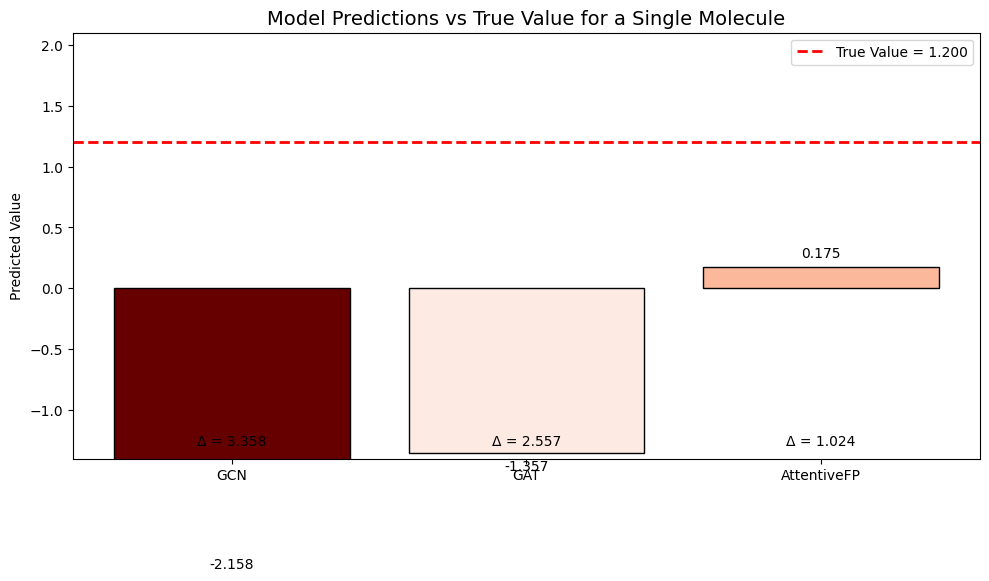

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['GCN', 'GAT', 'AttentiveFP']
predicted_values = [-2.1584, -1.3572, 0.1755]
true_value = 1.2
errors = [abs(p - true_value) for p in predicted_values]

# Bar colors
colors = ['#660000', '#fceae3', '#fcb89b']

# Create bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(models, predicted_values, color=colors, edgecolor='black')

# Annotate bars with predicted values
for bar, value in zip(bars, predicted_values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.05 * np.sign(height), 
            f"{value:.3f}", ha='center', va='bottom' if height >= 0 else 'top', fontsize=10)

# Annotate with Δ values (absolute errors)
for i, (bar, delta) in enumerate(zip(bars, errors)):
    ax.text(bar.get_x() + bar.get_width()/2, -1.2, 
            f"Δ = {delta:.3f}", ha='center', va='top', fontsize=10)

# Add horizontal true value line
ax.axhline(true_value, color='red', linestyle='--', linewidth=2, label=f"True Value = {true_value:.3f}")

# Title and labels
ax.set_title('Model Predictions vs True Value for a Single Molecule', fontsize=14)
ax.set_ylabel('Predicted Value')
ax.set_ylim(-1.4, 2.1)

# Add legend
ax.legend()

# Grid and layout tweaks
ax.grid(False)
plt.tight_layout()
plt.show()


## Effect of Training Parameters on model performance

Here, we will explore the effects of model training parameters (and small model changes) and how these affect model performance. Namely, we will explore the effects of:
* Number of layers used within the model
* Number of epochs used in training
* Learning rate
* Dropout rate


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import torch

def r2_rmse(dataloader, model):
    """
    Function to plot predictions vs actual values.
    This function however returns the R² score and RMSE.
    """
    all_preds = [] 
    all_targets = []

    # Put model in evaluation mode
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            preds = model(batch.x, batch.edge_index, batch.batch).squeeze()
            targets = batch.y.squeeze()

            # Handle possible shape mismatches
            if preds.dim() == 0:
                preds = preds.unsqueeze(0)
            if targets.dim() == 0:
                targets = targets.unsqueeze(0)

            all_preds.append(preds.cpu())
            all_targets.append(targets.cpu())

    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_targets = torch.cat(all_targets, dim=0).numpy()

    # Compute metrics
    r2 = r2_score(all_targets, all_preds)
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))

    print(f"R² score: {r2:.3f}")
    print(f"RMSE: {rmse:.3f}")
    
    return r2, rmse
    # Plot
    # plt.figure(figsize=(6, 6))
    # plt.scatter(all_targets, all_preds, alpha=0.7)
    # plt.plot([all_targets.min(), all_targets.max()],
    #          [all_targets.min(), all_targets.max()], 'r--')
    # plt.xlabel("Actual")
    # plt.ylabel("Predicted")
    # plt.title("Predicted vs. Actual - GCN Model (Batched)")
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()

### Number of layers


#### 1 Layer

In [ ]:
metrics_layers = {}

In [ ]:
import torch
from torch.nn import Linear, ReLU, Dropout, Sequential
from torch_geometric.nn import GCNConv, global_mean_pool

class GCNModel1L(torch.nn.Module):
    def __init__(self, in_channels, hidden_dim, out_dim=1, dropout_rate=0.2):
        super().__init__()

        # GCN layers
        self.conv1 = GCNConv(in_channels, hidden_dim)

        # Feedforward MLP for regression
        self.ffnn = Sequential(
            Linear(hidden_dim, hidden_dim),
            ReLU(),
            Dropout(dropout_rate),
            Linear(hidden_dim, out_dim)
        )

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        # batch = torch.zeros(x.size(0), dtype=torch.long)
        x = global_mean_pool(x, batch)
        out = self.ffnn(x)
        return out


In [ ]:
model_1L = GCNModel1L(in_channels=num_node_features, hidden_dim=64, out_dim=1)
print(model_1L)

GCNModel1L(
  (conv1): GCNConv(79, 64)
  (ffnn): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)


Epoch 1, Loss: 114.6381
Epoch 2, Loss: 175.3265
Epoch 3, Loss: 121.9366
Epoch 4, Loss: 96.4201
Epoch 5, Loss: 101.8534
Epoch 6, Loss: 154.4808
Epoch 7, Loss: 111.9304
Epoch 8, Loss: 125.6837
Epoch 9, Loss: 134.7020
Epoch 10, Loss: 99.6159
Epoch 11, Loss: 92.0230
Epoch 12, Loss: 93.6925
Epoch 13, Loss: 131.2416
Epoch 14, Loss: 90.0425
Epoch 15, Loss: 93.7852
Epoch 16, Loss: 78.7924
Epoch 17, Loss: 90.3664
Epoch 18, Loss: 75.8317
Epoch 19, Loss: 124.9226
Epoch 20, Loss: 83.6597
Epoch 21, Loss: 94.2316
Epoch 22, Loss: 111.3624
Epoch 23, Loss: 92.7675
Epoch 24, Loss: 71.9707
Epoch 25, Loss: 74.2511
Epoch 26, Loss: 77.7926
Epoch 27, Loss: 84.4021
Epoch 28, Loss: 95.1462
Epoch 29, Loss: 116.1851
Epoch 30, Loss: 87.0189
Epoch 31, Loss: 101.6411
Epoch 32, Loss: 84.8315
Epoch 33, Loss: 112.3074
Epoch 34, Loss: 75.1306
Epoch 35, Loss: 69.6891
Epoch 36, Loss: 90.8078
Epoch 37, Loss: 87.3002
Epoch 38, Loss: 98.6087
Epoch 39, Loss: 76.2134
Epoch 40, Loss: 100.2881
Epoch 41, Loss: 102.5647
Epoch 42,

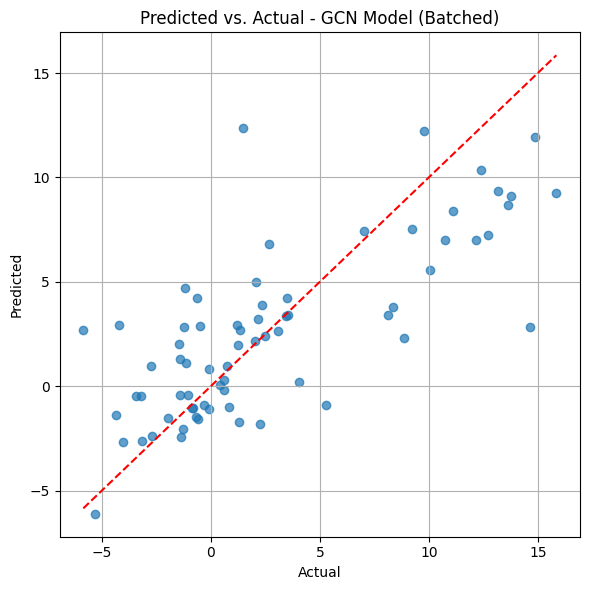

R² score: 0.569
RMSE: 3.718


In [ ]:
train_gcn_model_batched(train_loader, model_1L, lr=1e-3, epochs=300)
plot_predictions(train_loader, model_1L)
metrics_layers['1L'] = r2_rmse(train_loader, model_1L)

#### 2 Layers

In [ ]:
import torch
from torch.nn import Linear, ReLU, Dropout, Sequential
from torch_geometric.nn import GCNConv, global_mean_pool

class GCNModel2L(torch.nn.Module):
    def __init__(self, in_channels, hidden_dim, out_dim=1, dropout_rate=0.2):
        super().__init__()

        # GCN layers
        self.conv1 = GCNConv(in_channels, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)


        # Feedforward MLP for regression
        self.ffnn = Sequential(
            Linear(hidden_dim, hidden_dim),
            ReLU(),
            Dropout(dropout_rate),
            Linear(hidden_dim, out_dim)
        )

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)

        x = self.conv2(x, edge_index)
        x = torch.relu(x)

        # batch = torch.zeros(x.size(0), dtype=torch.long)
        x = global_mean_pool(x, batch)
        out = self.ffnn(x)
        return out


In [ ]:
model_2L = GCNModel2L(in_channels=num_node_features, hidden_dim=64, out_dim=1)
print(model_2L)

GCNModel2L(
  (conv1): GCNConv(79, 64)
  (conv2): GCNConv(64, 64)
  (ffnn): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)


Epoch 1, Loss: 143.1179
Epoch 2, Loss: 105.0561
Epoch 3, Loss: 122.2453
Epoch 4, Loss: 117.3773
Epoch 5, Loss: 121.4211
Epoch 6, Loss: 85.6544
Epoch 7, Loss: 89.6924
Epoch 8, Loss: 109.2885
Epoch 9, Loss: 100.8855
Epoch 10, Loss: 82.2843
Epoch 11, Loss: 78.0112
Epoch 12, Loss: 82.8116
Epoch 13, Loss: 76.3704
Epoch 14, Loss: 101.2947
Epoch 15, Loss: 88.0385
Epoch 16, Loss: 97.4610
Epoch 17, Loss: 96.2178
Epoch 18, Loss: 97.3094
Epoch 19, Loss: 90.8293
Epoch 20, Loss: 99.1282
Epoch 21, Loss: 114.5037
Epoch 22, Loss: 79.5120
Epoch 23, Loss: 99.0287
Epoch 24, Loss: 75.8807
Epoch 25, Loss: 83.5916
Epoch 26, Loss: 86.3623
Epoch 27, Loss: 94.1355
Epoch 28, Loss: 95.6734
Epoch 29, Loss: 82.5794
Epoch 30, Loss: 101.2730
Epoch 31, Loss: 85.1523
Epoch 32, Loss: 108.9975
Epoch 33, Loss: 73.0892
Epoch 34, Loss: 76.3241
Epoch 35, Loss: 66.9599
Epoch 36, Loss: 96.3693
Epoch 37, Loss: 65.0487
Epoch 38, Loss: 93.0357
Epoch 39, Loss: 76.4835
Epoch 40, Loss: 70.3308
Epoch 41, Loss: 91.9247
Epoch 42, Loss

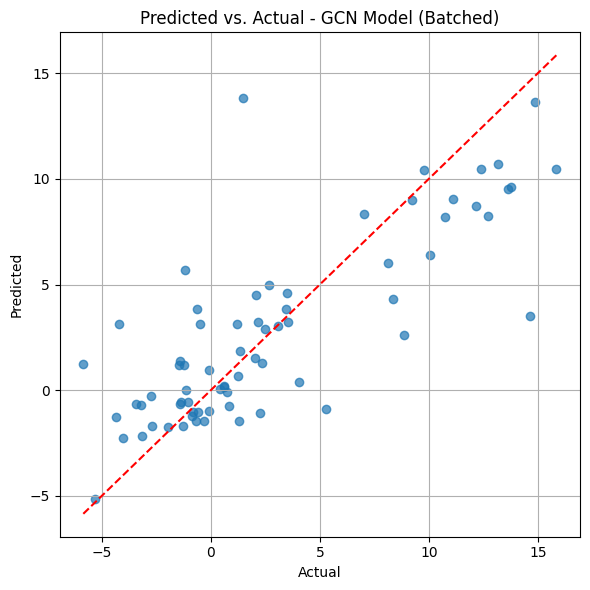

R² score: 0.639
RMSE: 3.400


In [ ]:
train_gcn_model_batched(train_loader, model_2L, lr=1e-3, epochs=300)
plot_predictions(train_loader, model_2L)
metrics_layers['2L'] = r2_rmse(train_loader, model_2L)


#### 3 Layers

In [ ]:
import torch
from torch.nn import Linear, ReLU, Dropout, Sequential
from torch_geometric.nn import GCNConv, global_mean_pool

class GCNModel3L(torch.nn.Module):
    def __init__(self, in_channels, hidden_dim, out_dim=1, dropout_rate=0.2):
        super().__init__()

        # GCN layers
        self.conv1 = GCNConv(in_channels, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)

        # Feedforward MLP for regression
        self.ffnn = Sequential(
            Linear(hidden_dim, hidden_dim),
            ReLU(),
            Dropout(dropout_rate),
            Linear(hidden_dim, out_dim)
        )

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)

        x = self.conv2(x, edge_index)
        x = torch.relu(x)

        x = self.conv3(x, edge_index)
        x = torch.relu(x)

        # batch = torch.zeros(x.size(0), dtype=torch.long)
        x = global_mean_pool(x, batch)
        out = self.ffnn(x)
        return out


In [ ]:
model_3L = GCNModel3L(in_channels=num_node_features, hidden_dim=64, out_dim=1)
print(model_3L)

GCNModel3L(
  (conv1): GCNConv(79, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (ffnn): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [ ]:
train_gcn_model_batched(train_loader, model_3L, epochs=300, lr=1e-3)

Epoch 1, Loss: 125.0185
Epoch 2, Loss: 121.7184
Epoch 3, Loss: 108.1181
Epoch 4, Loss: 155.6284
Epoch 5, Loss: 131.9154
Epoch 6, Loss: 107.3109
Epoch 7, Loss: 121.2760
Epoch 8, Loss: 130.5908
Epoch 9, Loss: 84.1562
Epoch 10, Loss: 122.4384
Epoch 11, Loss: 95.0687
Epoch 12, Loss: 82.4126
Epoch 13, Loss: 80.1982
Epoch 14, Loss: 117.9585
Epoch 15, Loss: 78.9671
Epoch 16, Loss: 99.9395
Epoch 17, Loss: 106.9522
Epoch 18, Loss: 100.3798
Epoch 19, Loss: 73.2886
Epoch 20, Loss: 87.7114
Epoch 21, Loss: 96.3042
Epoch 22, Loss: 98.7079
Epoch 23, Loss: 87.8156
Epoch 24, Loss: 103.9409
Epoch 25, Loss: 84.8404
Epoch 26, Loss: 106.5805
Epoch 27, Loss: 80.5384
Epoch 28, Loss: 105.3273
Epoch 29, Loss: 98.4556
Epoch 30, Loss: 88.8562
Epoch 31, Loss: 73.9354
Epoch 32, Loss: 104.9024
Epoch 33, Loss: 91.1245
Epoch 34, Loss: 74.0246
Epoch 35, Loss: 80.9540
Epoch 36, Loss: 67.4925
Epoch 37, Loss: 73.8538
Epoch 38, Loss: 72.5813
Epoch 39, Loss: 95.8041
Epoch 40, Loss: 79.8829
Epoch 41, Loss: 72.4605
Epoch 42,

GCNModel3L(
  (conv1): GCNConv(79, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (ffnn): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)

R² score: 0.672
RMSE: 3.241


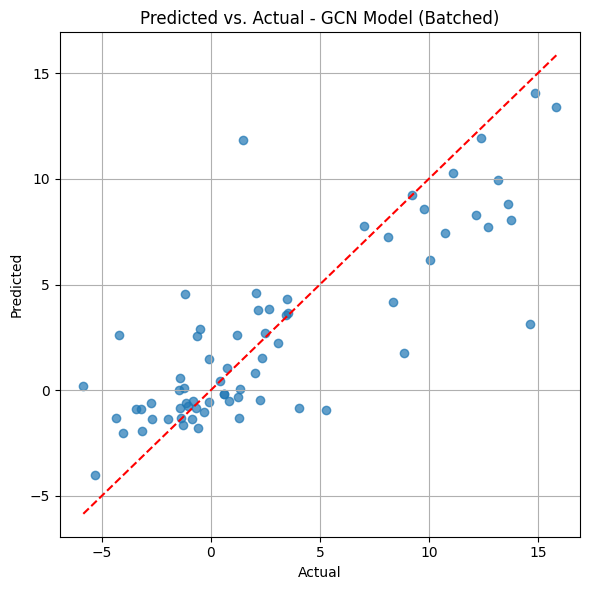

R² score: 0.672
RMSE: 3.241


In [ ]:
plot_predictions(train_loader, model_3L)
metrics_layers['3L'] = r2_rmse(train_loader, model_3L)

In [ ]:
metrics_layers

{'1L': (0.5688022375106812, np.float64(3.7183990312896755)),
 '2L': (0.6394141316413879, np.float64(3.400338178533652)),
 '3L': (0.6724008917808533, np.float64(3.2410751456847753))}

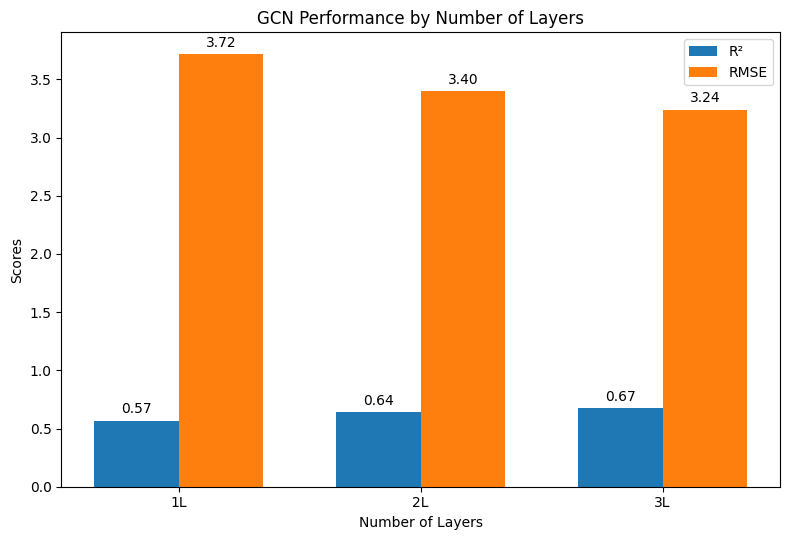

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract labels and scores
labels = list(metrics_layers.keys())
r2_scores = [v[0] for v in metrics_layers.values()]
rmse_scores = [v[1] for v in metrics_layers.values()]

# X positions for each group
x = np.arange(len(labels))

# Bar width
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5.5))

# Bars for R2
bars1 = ax.bar(x - width/2, r2_scores, width, label='R²')

# Bars for RMSE
bars2 = ax.bar(x + width/2, rmse_scores, width, label='RMSE')

# Labels and formatting
ax.set_xlabel('Number of Layers')
ax.set_ylabel('Scores')
ax.set_title('GCN Performance by Number of Layers')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Optionally add value labels on top
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()


### Number of Epochs

In [ ]:
epochs = [100, 200, 300, 400, 500]
metrics_epoch = {}
for epoch in [100, 200, 300, 400, 500]:
    model3 = GCNModel(in_channels=num_node_features, hidden_dim=64, out_dim=1)
    train_gcn_model_batched(train_loader, model3, epochs=epoch, lr=1e-3)
    metrics_epoch[epoch] = r2_rmse(train_loader, model3)
metrics_epoch

Epoch 1, Loss: 93.9448
Epoch 2, Loss: 116.2533
Epoch 3, Loss: 112.3504
Epoch 4, Loss: 144.0532
Epoch 5, Loss: 117.0382
Epoch 6, Loss: 109.0063
Epoch 7, Loss: 91.0506
Epoch 8, Loss: 88.1442
Epoch 9, Loss: 92.3456
Epoch 10, Loss: 112.5036
Epoch 11, Loss: 120.2108
Epoch 12, Loss: 136.6870
Epoch 13, Loss: 89.3840
Epoch 14, Loss: 94.4108
Epoch 15, Loss: 84.9122
Epoch 16, Loss: 105.6575
Epoch 17, Loss: 93.4058
Epoch 18, Loss: 87.9674
Epoch 19, Loss: 83.5233
Epoch 20, Loss: 78.5502
Epoch 21, Loss: 84.9091
Epoch 22, Loss: 100.6857
Epoch 23, Loss: 93.2660
Epoch 24, Loss: 83.1009
Epoch 25, Loss: 99.3422
Epoch 26, Loss: 101.1705
Epoch 27, Loss: 91.3450
Epoch 28, Loss: 126.1465
Epoch 29, Loss: 105.0476
Epoch 30, Loss: 74.2592
Epoch 31, Loss: 102.3210
Epoch 32, Loss: 80.8161
Epoch 33, Loss: 93.6040
Epoch 34, Loss: 89.0745
Epoch 35, Loss: 76.3528
Epoch 36, Loss: 78.0586
Epoch 37, Loss: 103.3607
Epoch 38, Loss: 86.0878
Epoch 39, Loss: 99.0615
Epoch 40, Loss: 73.1171
Epoch 41, Loss: 104.4680
Epoch 42,

{100: (0.38805437088012695, np.float64(4.42969847985577)),
 200: (0.4906439185142517, np.float64(4.041368663590198)),
 300: (0.5448567271232605, np.float64(3.820250340991632)),
 400: (0.5770187973976135, np.float64(3.682801178569653)),
 500: (0.6233918070793152, np.float64(3.475062357391065))}

In [ ]:
for key, value in metrics_epoch.items():
    print(f"Epochs: {key}, R²: {value[0]:.3f}, RMSE: {value[1]:.3f}")

Epochs: 100, R²: 0.388, RMSE: 4.430
Epochs: 200, R²: 0.491, RMSE: 4.041
Epochs: 300, R²: 0.545, RMSE: 3.820
Epochs: 400, R²: 0.577, RMSE: 3.683
Epochs: 500, R²: 0.623, RMSE: 3.475


In [ ]:
graph_list[0].y

tensor([5.2900])

In [ ]:
# Exploreing the variance of all Inhibition POwer values in the dataset as a possible source of error
targets = []
for graph in graph_list:
    targets.append(graph.y.item())
np.var(targets)

np.float64(32.06530972525442)

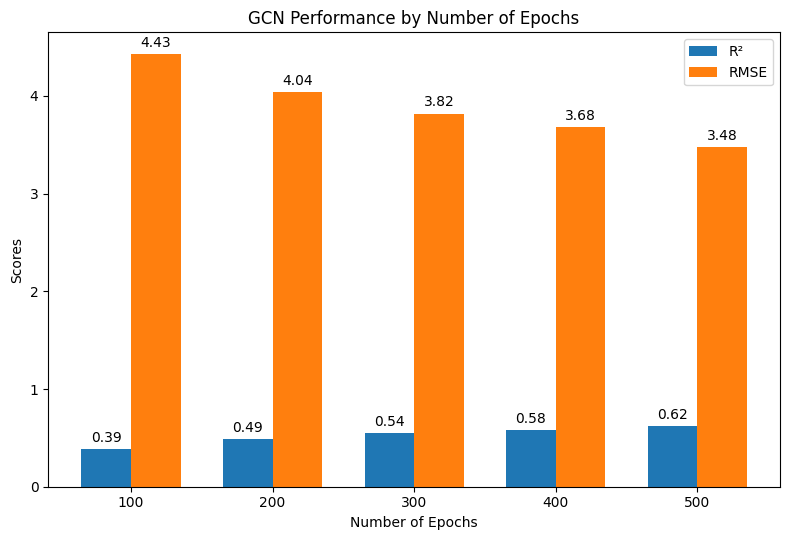

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract labels and scores
labels = list(metrics_epoch.keys())
r2_scores = [v[0] for v in metrics_epoch.values()]
rmse_scores = [v[1] for v in metrics_epoch.values()]

# X positions for each group
x = np.arange(len(labels))

# Bar width
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5.5))

# Bars for R2
bars1 = ax.bar(x - width/2, r2_scores, width, label='R²')

# Bars for RMSE
bars2 = ax.bar(x + width/2, rmse_scores, width, label='RMSE')

# Labels and formatting
ax.set_xlabel('Number of Epochs')
ax.set_ylabel('Scores')
ax.set_title('GCN Performance by Number of Epochs')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Optionally add value labels on top
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()


### Learning rate

In [ ]:
lrs = [1e-1 ,1e-2 ,1e-3, 1e-4, 1e-5, 1e-6]
obsv_lr_metrics = {}

for lr in lrs:
    model_e3 = GCNModel(in_channels=num_node_features, hidden_dim=64, out_dim=1)
    train_gcn_model_batched(train_loader, model_e3, epochs=300, lr=lr)
    obsv_lr_metrics[lr] = r2_rmse(train_loader, model_e3)
    print(f"Learning Rate: {lr}, R²: {obsv_lr_metrics[lr][0]:.3f}, RMSE: {obsv_lr_metrics[lr][1]:.3f}")

Epoch 1, Loss: 212.6717
Epoch 2, Loss: 92.2641
Epoch 3, Loss: 87.0421
Epoch 4, Loss: 158.7701
Epoch 5, Loss: 93.2574
Epoch 6, Loss: 87.7157
Epoch 7, Loss: 117.1743
Epoch 8, Loss: 119.4635
Epoch 9, Loss: 92.3017
Epoch 10, Loss: 100.4900
Epoch 11, Loss: 91.0675
Epoch 12, Loss: 108.9264
Epoch 13, Loss: 86.7497
Epoch 14, Loss: 90.0539
Epoch 15, Loss: 86.5904
Epoch 16, Loss: 80.9007
Epoch 17, Loss: 97.4324
Epoch 18, Loss: 82.0065
Epoch 19, Loss: 100.1974
Epoch 20, Loss: 103.0309
Epoch 21, Loss: 103.0864
Epoch 22, Loss: 95.3326
Epoch 23, Loss: 112.2231
Epoch 24, Loss: 76.4220
Epoch 25, Loss: 78.5109
Epoch 26, Loss: 86.4566
Epoch 27, Loss: 101.4934
Epoch 28, Loss: 88.9432
Epoch 29, Loss: 82.5410
Epoch 30, Loss: 86.1367
Epoch 31, Loss: 115.0256
Epoch 32, Loss: 93.1730
Epoch 33, Loss: 112.8126
Epoch 34, Loss: 81.6055
Epoch 35, Loss: 110.1897
Epoch 36, Loss: 99.3156
Epoch 37, Loss: 118.1375
Epoch 38, Loss: 101.1929
Epoch 39, Loss: 77.8040
Epoch 40, Loss: 85.7047
Epoch 41, Loss: 95.4407
Epoch 42,

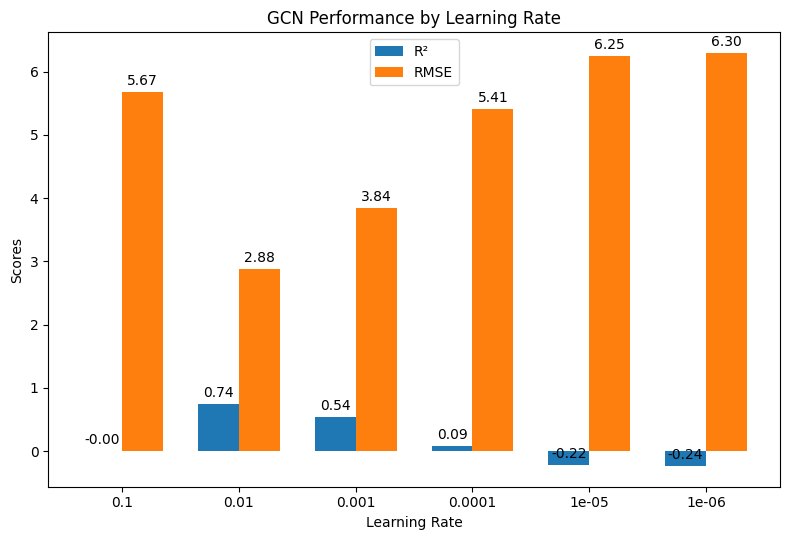

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract labels and scores
labels = list(obsv_lr_metrics.keys())
r2_scores = [v[0] for v in obsv_lr_metrics.values()]
rmse_scores = [v[1] for v in obsv_lr_metrics.values()]

# X positions for each group
x = np.arange(len(labels))

# Bar width
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5.5))

# Bars for R2
bars1 = ax.bar(x - width/2, r2_scores, width, label='R²')

# Bars for RMSE
bars2 = ax.bar(x + width/2, rmse_scores, width, label='RMSE')

# Labels and formatting
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Scores')
ax.set_title('GCN Performance by Learning Rate')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Optionally add value labels on top
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()


### Dropout Rate

In [ ]:
dropout_rates = [0.1, 0.2, 0.3, 0.4, 0.5]
obsv_dropout_metrics = {}

for dr in dropout_rates:
    model_dr = GCNModel(in_channels=num_node_features, hidden_dim=64, out_dim=1, dropout_rate=dr)
    train_gcn_model_batched(train_loader, model_dr, epochs=300, lr=1e-3)
    obsv_dropout_metrics[dr] = r2_rmse(train_loader, model_dr)


Epoch 1, Loss: 140.7889
Epoch 2, Loss: 134.1742
Epoch 3, Loss: 126.2250
Epoch 4, Loss: 125.8269
Epoch 5, Loss: 107.8827
Epoch 6, Loss: 93.6964
Epoch 7, Loss: 105.2524
Epoch 8, Loss: 85.9008
Epoch 9, Loss: 90.3303
Epoch 10, Loss: 104.7873
Epoch 11, Loss: 146.4538
Epoch 12, Loss: 104.0569
Epoch 13, Loss: 82.8058
Epoch 14, Loss: 80.8713
Epoch 15, Loss: 111.8281
Epoch 16, Loss: 94.0347
Epoch 17, Loss: 103.5929
Epoch 18, Loss: 96.5953
Epoch 19, Loss: 116.6792
Epoch 20, Loss: 131.3361
Epoch 21, Loss: 106.9268
Epoch 22, Loss: 88.8934
Epoch 23, Loss: 82.5614
Epoch 24, Loss: 74.7225
Epoch 25, Loss: 91.2411
Epoch 26, Loss: 74.0422
Epoch 27, Loss: 90.5184
Epoch 28, Loss: 106.1125
Epoch 29, Loss: 88.1212
Epoch 30, Loss: 112.7362
Epoch 31, Loss: 111.0136
Epoch 32, Loss: 84.6172
Epoch 33, Loss: 91.3360
Epoch 34, Loss: 93.0034
Epoch 35, Loss: 100.0811
Epoch 36, Loss: 76.2518
Epoch 37, Loss: 75.2839
Epoch 38, Loss: 76.9463
Epoch 39, Loss: 108.9737
Epoch 40, Loss: 77.3265
Epoch 41, Loss: 80.8100
Epoch 

In [ ]:
obsv_dropout_metrics

{0.1: (0.5614262819290161, np.float64(3.7500670109165712)),
 0.2: (0.5530880689620972, np.float64(3.7855475098512263)),
 0.3: (0.5688843727111816, np.float64(3.7180448232147607)),
 0.4: (0.5213991403579712, np.float64(3.9174591371977026)),
 0.5: (0.5191582441329956, np.float64(3.9266193766787585))}

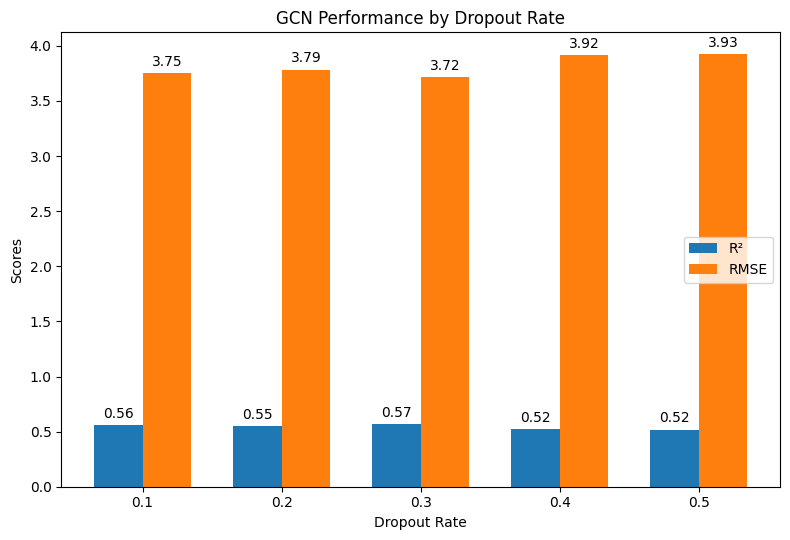

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract labels and scores
labels = list(obsv_dropout_metrics.keys())
r2_scores = [v[0] for v in obsv_dropout_metrics.values()]
rmse_scores = [v[1] for v in obsv_dropout_metrics.values()]

# X positions for each group
x = np.arange(len(labels))

# Bar width
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5.5))

# Bars for R2
bars1 = ax.bar(x - width/2, r2_scores, width, label='R²')

# Bars for RMSE
bars2 = ax.bar(x + width/2, rmse_scores, width, label='RMSE')

# Labels and formatting
ax.set_xlabel('Dropout Rate')
ax.set_ylabel('Scores')
ax.set_title('GCN Performance by Dropout Rate')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Optionally add value labels on top
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()


## Investigating model inconsistency due to batching



In [ ]:
from torch.nn import MSELoss
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch

# TODO:
batch = Batch.from_data_list(graph_list)
in_channels = batch.x.size(1)
# train_loader = DataLoader(graph_list, batch_size=32, shuffle=True)


def train_gcn_fullbatch(batch, model, lr=1e-3, epochs=300):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = MSELoss()

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch).squeeze()
        target = batch.y.squeeze()

        assert out.shape == target.shape, f"{out.shape=} vs {target.shape=}"
        loss = loss_fn(out, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")
    
    return model



In [ ]:
batches = [1, 2, 4,8, 16, 32, 64, 70]
metrics_batches = {}
for batch_size in batches:
    train_loader = DataLoader(graph_list, batch_size=batch_size, shuffle=True)
    model_b = GCNModel(in_channels=in_channels, hidden_dim=64, out_dim=1)
    print(f"Training with batch size: {batch_size}")
    train_gcn_model_batched(train_loader, model_b, lr=1e-3, epochs=300)
    # plot_predictions(train_loader, model_b)
    metrics_batches[batch_size] = r2_rmse(train_loader, model_b)



Training with batch size: 1
Epoch 1, Loss: 2730.4838
Epoch 2, Loss: 2442.7566
Epoch 3, Loss: 2327.9871
Epoch 4, Loss: 2205.8793
Epoch 5, Loss: 2212.9833
Epoch 6, Loss: 2112.8604
Epoch 7, Loss: 2064.4767
Epoch 8, Loss: 2093.6282
Epoch 9, Loss: 1971.6786
Epoch 10, Loss: 1908.6971
Epoch 11, Loss: 1857.0187
Epoch 12, Loss: 1761.8247
Epoch 13, Loss: 1680.2908
Epoch 14, Loss: 1648.7219
Epoch 15, Loss: 1580.5500
Epoch 16, Loss: 1585.5906
Epoch 17, Loss: 1533.5476
Epoch 18, Loss: 1559.8012
Epoch 19, Loss: 1503.9690
Epoch 20, Loss: 1387.5246
Epoch 21, Loss: 1504.3365
Epoch 22, Loss: 1347.8583
Epoch 23, Loss: 1300.5576
Epoch 24, Loss: 1320.7778
Epoch 25, Loss: 1377.6283
Epoch 26, Loss: 1407.2136
Epoch 27, Loss: 1356.4047
Epoch 28, Loss: 1366.3277
Epoch 29, Loss: 1236.5248
Epoch 30, Loss: 1284.8564
Epoch 31, Loss: 1221.5036
Epoch 32, Loss: 1277.0257
Epoch 33, Loss: 1301.5312
Epoch 34, Loss: 1221.1743
Epoch 35, Loss: 1220.6792
Epoch 36, Loss: 1239.4816
Epoch 37, Loss: 1088.2555
Epoch 38, Loss: 113

In [ ]:
for key, value in metrics_batches.items():
    print(f"Batch Size: {key}, R²: {value[0]:.3f}, RMSE: {value[1]:.3f}")

Batch Size: 1, R²: 0.854, RMSE: 2.165
Batch Size: 2, R²: 0.691, RMSE: 3.146
Batch Size: 4, R²: 0.679, RMSE: 3.210
Batch Size: 8, R²: 0.660, RMSE: 3.303
Batch Size: 16, R²: 0.614, RMSE: 3.518
Batch Size: 32, R²: 0.531, RMSE: 3.878
Batch Size: 64, R²: 0.474, RMSE: 4.109
Batch Size: 70, R²: 0.528, RMSE: 3.892


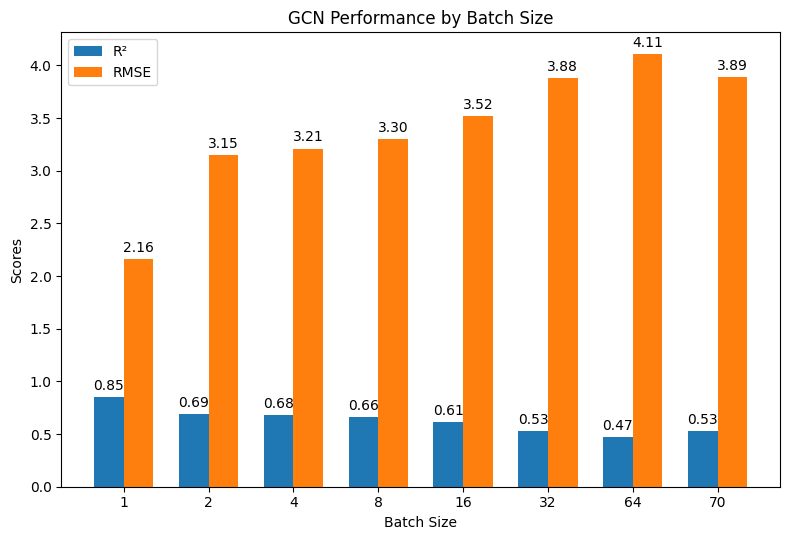

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract labels and scores
labels = list(metrics_batches.keys())
r2_scores = [v[0] for v in metrics_batches.values()]
rmse_scores = [v[1] for v in metrics_batches.values()]

# X positions for each group
x = np.arange(len(labels))

# Bar width
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5.5))

# Bars for R2
bars1 = ax.bar(x - width/2, r2_scores, width, label='R²')

# Bars for RMSE
bars2 = ax.bar(x + width/2, rmse_scores, width, label='RMSE')

# Labels and formatting
ax.set_xlabel('Batch Size')
ax.set_ylabel('Scores')
ax.set_title('GCN Performance by Batch Size')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Optionally add value labels on top
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()


GCNModel(
  (conv1): GCNConv(79, 64)
  (ffnn): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)
Epoch 1, Loss: 40.0593
Epoch 2, Loss: 39.9480
Epoch 3, Loss: 39.8529
Epoch 4, Loss: 39.7232
Epoch 5, Loss: 39.5206
Epoch 6, Loss: 39.3094
Epoch 7, Loss: 39.2593
Epoch 8, Loss: 39.1318
Epoch 9, Loss: 38.9429
Epoch 10, Loss: 38.7850
Epoch 11, Loss: 38.5376
Epoch 12, Loss: 38.4738
Epoch 13, Loss: 38.3000
Epoch 14, Loss: 37.9955
Epoch 15, Loss: 37.9057
Epoch 16, Loss: 37.7361
Epoch 17, Loss: 37.5597
Epoch 18, Loss: 37.1667
Epoch 19, Loss: 36.8514
Epoch 20, Loss: 36.6879
Epoch 21, Loss: 36.4732
Epoch 22, Loss: 36.1929
Epoch 23, Loss: 36.0124
Epoch 24, Loss: 35.6970
Epoch 25, Loss: 35.3613
Epoch 26, Loss: 35.2777
Epoch 27, Loss: 34.6596
Epoch 28, Loss: 34.6749
Epoch 29, Loss: 34.0480
Epoch 30, Loss: 34.0020
Epoch 31, Loss: 33.6331
Epoch 32, Loss: 33.6913
Ep

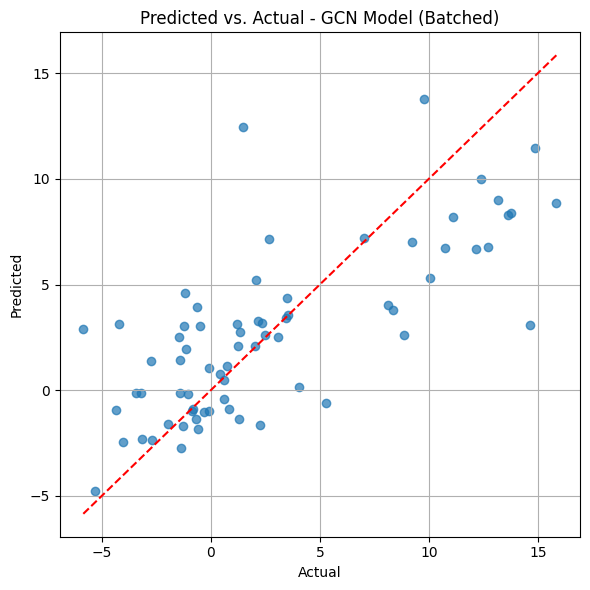

AttributeError: 'tuple' object has no attribute 'x'

In [ ]:
# Experimenting with Batch.from_list() functionality
model_b = GCNModel(in_channels=in_channels, hidden_dim=64, out_dim=1)
print(model_b)

train_gcn_fullbatch(batch, model_b, lr=1e-3, epochs=300)
plot_predictions(graph_list, model_b)
# metrics_batches['Batch'] = r2_rmse(batch, model_b)
# Need to change plot predictions function to handle full batch